In [2]:
import pandas as pd
import numpy as np

In [3]:
path='Dades/datos_preprocesados.csv'
path_wei= 'Dades/dt_model.csv'
df=pd.read_csv(path_wei)
df_old=pd.read_csv(path)

In [4]:
# Ver todas las columnas disponibles
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

Columnas disponibles en el dataset:
['codigo_participante', 'recidiva', 'recidiva_exitus', 'diferencia_dias_reci_exit', 'causa_muerte', 'edad', 'imc', 'tipo_histologico', 'Grado', 'valor_de_ca125', 'ecotv_infiltsub', 'ecotv_infiltobj', 'metasta_distan', 'grupo_riesgo', 'despues_diag', 'estadiaje_pre_i', 'est_pcte', 'libre_enferm', 'numero_de_recid', 'dx_recidiva', 'num_recidiva', 'loc_recidiva_r01', 'loc_recidiva_r02', 'loc_recidiva_r03', 'loc_recidiva_r04', 'loc_recidiva_r05', 'loc_recidiva_r06', 'tto_recidiva', 'Tt_recidiva_qx', 'Reseccion_macroscopica_complet', 'Tratamiento_RT', 'Tratamiento_sistemico', 'estado', 'usuario_reg1', 'hsp_trat_primario', 'presntado_cTG', 'tto_NA', 'ciclos_tto_NAdj', 'tto_1_quirugico', 'inten_tto', 'abordajeqx', 'tec_Qx', 'motivonolaparos', 'conver_laparo', 'Motivo_de_conversion_a_LPT_r01', 'Motivo_de_conversion_a_LPT_r02', 'Motivo_de_conversion_a_LPT_r03', 'Motivo_de_conversion_a_LPT_r04', 'Tec_histerec', 'Anexectomia', 'omentectomia', 'Perforacion_uteri

## Variables Target 

In [5]:
df_Y = df_old.copy()

# Convertir a datetime
date_cols = [
    "f_diag",
    "fecha_de_recidi",
    "f_muerte",
    "Ultima_fecha"
]

for col in date_cols:
    df_Y[col] = pd.to_datetime(df_Y[col], errors="coerce", dayfirst=True)

C:\Users\sylbo\AppData\Local\Temp\ipykernel_30404\3006927505.py:12: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_Y[col] = pd.to_datetime(df_Y[col], errors="coerce", dayfirst=True)


In [6]:
df_Y["fecha_evento_rfs"] = df_Y[["fecha_de_recidi", "f_muerte"]].min(axis=1)


In [7]:
df_Y["evento_rfs"] = np.where(
    (df_old["recidiva"] == 1) | (df_old["estado"] == 1),
    1,
    0
)


In [8]:
df_Y['evento_rfs'].value_counts()

evento_rfs
0    132
1     31
Name: count, dtype: int64

In [9]:
df_Y["fecha_fin_rfs"] = np.where(
    df_Y["evento_rfs"] == 1,
    df_Y["fecha_evento_rfs"],
    df_Y["Ultima_fecha"]
)

df_Y["fecha_fin_rfs"] = pd.to_datetime(df_Y["fecha_fin_rfs"])


In [10]:
#tiempo de seguimiento
df_Y["tiempo_rfs_dias"] = (
    df_Y["fecha_fin_rfs"] - df_Y["f_diag"]).dt.days



#neteja min
df_Y = df_Y[
    df_Y["tiempo_rfs_dias"].notna() &
    (df_Y["tiempo_rfs_dias"] > 0)
]

In [11]:
print("Eventos RFS:", df_Y["evento_rfs"].sum())
print("Censurados:", (df_Y["evento_rfs"] == 0).sum())
print("Mediana seguimiento (dies):", df_Y["tiempo_rfs_dias"].median())


Eventos RFS: 12
Censurados: 62
Mediana seguimiento (dies): 911.0


In [12]:
df_Y[["tiempo_rfs_dias"]].describe()


,tiempo_rfs_dias
count,74.000000
mean,1112.378378
std,678.341525
min,93.000000
25%,556.750000
50%,911.000000
75%,1740.500000
max,2461.000000


In [13]:
df_Y['tiempo_rfs_dias'].value_counts()

tiempo_rfs_dias
556.0     2
1743.0    1
1225.0    1
1988.0    1
823.0     1
         ..
409.0     1
568.0     1
192.0     1
93.0      1
453.0     1
Name: count, Length: 73, dtype: int64

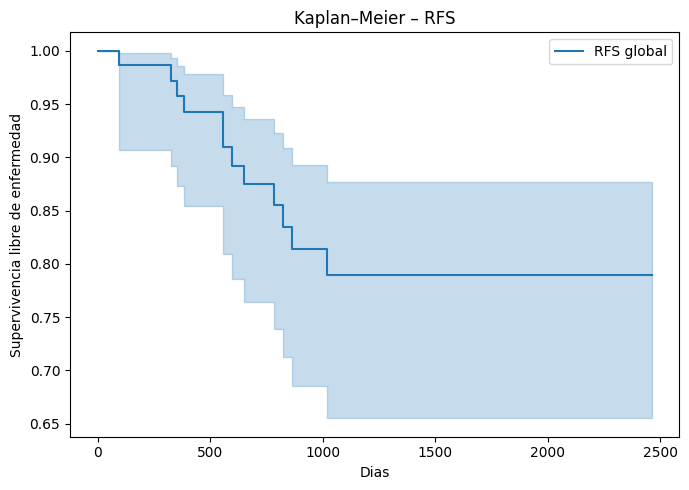

In [14]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(7,5))
kmf.fit(
    durations=df_Y["tiempo_rfs_dias"],
    event_observed=df_Y["evento_rfs"],
    label="RFS global"
)

kmf.plot(ci_show=True)
plt.xlabel("Dias")
plt.ylabel("Supervivencia libre de enfermedad")
plt.title("Kaplan–Meier – RFS")
plt.tight_layout()
plt.show()


## Fase1: seleccionar variables predicctores importants


In [15]:
df.columns

Index(['codigo_participante', 'recidiva', 'recidiva_exitus',
       'diferencia_dias_reci_exit', 'causa_muerte', 'edad', 'imc',
       'tipo_histologico', 'Grado', 'valor_de_ca125',
       ...
       'rt_dosis', 'n_doisis_rt', 'moti_no_RT', 'bqt', 'bt_realPac', 'qt',
       'Tratamiento_sistemico_realizad', 'edad_en_cirugia', 'event',
       'time_days'],
      dtype='object', length=162)

**tratar col numero_de_recid** --> NO ES PREDICTORA (SERA DESCRIPTIVA EN TODO CASO)
- tindre valor vol dir que ha tingut recibida i s'ha localitzat en X lloc.      
    
Ficar valor 10 a persones no s'han fet la prova (perque no han tingut)
En var: numero_de_recid --> si te missing --> NO S'HA TROBAT RECIBIDA  
Seria igual a valor 0



In [16]:
vars_outcome_recidiva = [
    "recidiva", "fecha_de_recidi", "numero_de_recid", "num_recidiva",
    "libre_enferm", "estado", "f_muerte", "causa_muerte"
]

vars_post_recidiva = [
    "dx_recidiva", "loc_recidiva_r01", "loc_recidiva_r02", "loc_recidiva_r03",
    "loc_recidiva_r04", "loc_recidiva_r05", "loc_recidiva_r06",
    "tto_recidiva", "Tt_recidiva_qx", "Reseccion_macroscopica_complet"
]

vars_predictoras_candidatas = [
    "edad", "imc", "tipo_histologico", "Grado", "valor_de_ca125",
    "ecotv_infiltsub", "ecotv_infiltobj", "metasta_distan",
    "grupo_riesgo", "estadiaje_pre_i", "asa", "histo_defin",
    "grado_histologi", "tamano_tumoral", "afectacion_linf",
    "AP_centinela_pelvico", "AP_ganPelv", "AP_glanPaor",
    "recep_est_porcent", "rece_de_Ppor", "beta_cateninap",
    "FIGO2023", "grupo_de_riesgo_definitivo", 'event', 'edad_en_cirugia',"time_days" 
]


In [17]:
##MIRAR MISSING PREDICTORAS
missing_summary = (
    df[vars_predictoras_candidatas]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="pct_missing")
)

missing_summary["pct_missing"] = missing_summary["pct_missing"] * 100
missing_summary


,pct_missing
valor_de_ca125,88.435374
AP_glanPaor,78.231293
AP_ganPelv,62.585034
rece_de_Ppor,42.857143
recep_est_porcent,41.496599
AP_centinela_pelvico,12.925170
tamano_tumoral,12.244898
beta_cateninap,6.802721
asa,6.122449
grupo_de_riesgo_definitivo,6.122449


In [18]:
# Identificar variables con más del 60% de missing
vars_to_drop = missing_summary[missing_summary["pct_missing"] > 60].index.tolist()

print(f"Variables a eliminar (>60% missing): {vars_to_drop}")
print(f"Total variables a eliminar: {len(vars_to_drop)}")

# Eliminar del dataframe original
df = df.drop(columns=vars_to_drop)

# Actualizar la lista de variables predictoras candidatas
vars_predictoras_candidatas = [v for v in vars_predictoras_candidatas if v not in vars_to_drop]

print(f"\nVariables predictoras restantes: {len(vars_predictoras_candidatas)}")
print(vars_predictoras_candidatas)

Variables a eliminar (>60% missing): ['valor_de_ca125', 'AP_glanPaor', 'AP_ganPelv']
Total variables a eliminar: 3

Variables predictoras restantes: 23
['edad', 'imc', 'tipo_histologico', 'Grado', 'ecotv_infiltsub', 'ecotv_infiltobj', 'metasta_distan', 'grupo_riesgo', 'estadiaje_pre_i', 'asa', 'histo_defin', 'grado_histologi', 'tamano_tumoral', 'afectacion_linf', 'AP_centinela_pelvico', 'recep_est_porcent', 'rece_de_Ppor', 'beta_cateninap', 'FIGO2023', 'grupo_de_riesgo_definitivo', 'event', 'edad_en_cirugia', 'time_days']


**Missing per pacient**

In [19]:
df_pred = df[vars_predictoras_candidatas]

df["n_missing_pred"] = df_pred.isna().sum(axis=1)
df["pct_missing_pred"] = df["n_missing_pred"] / len(vars_predictoras_candidatas) * 100

df["pct_missing_pred"].describe()


count    147.000000
mean       6.713990
std        9.134706
min        0.000000
25%        0.000000
50%        4.347826
75%        8.695652
max       47.826087
Name: pct_missing_pred, dtype: float64

In [20]:
df.loc[
    df["pct_missing_pred"] > 60,
    ["pct_missing_pred"]
].shape


(0, 1)

In [21]:
# Eliminar pacientes con >60% missing en predictores
df = df[df["pct_missing_pred"] <= 60].copy()
print(f"Pacientes restantes tras filtrar: {df.shape[0]}")

Pacientes restantes tras filtrar: 147


**Analisis de correlacion**

In [22]:
df_pred = df[vars_predictoras_candidatas].copy()


In [23]:
num_vars = df_pred.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_vars = df_pred.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numéricas:", num_vars)
print("Categóricas:", cat_vars)


Numéricas: ['edad', 'imc', 'tipo_histologico', 'Grado', 'ecotv_infiltsub', 'ecotv_infiltobj', 'metasta_distan', 'grupo_riesgo', 'estadiaje_pre_i', 'asa', 'histo_defin', 'grado_histologi', 'tamano_tumoral', 'afectacion_linf', 'AP_centinela_pelvico', 'recep_est_porcent', 'rece_de_Ppor', 'beta_cateninap', 'FIGO2023', 'grupo_de_riesgo_definitivo', 'event', 'edad_en_cirugia', 'time_days']
Categóricas: []


realment no totes son numeriques: HI HA MOLTES CATEG CODIFICADES:   
**Num cont**   
edad
imc
tamano_tumoral
valor_de_ca125   (si la vuelves a incluir)
recep_est_porcent
rece_de_Ppor
**************
**catg**  
Grado
grado_histologi
FIGO2023
asa
grupo_riesgo
grupo_de_riesgo_definitivo
estadiaje_pre_i
****************
**Bi**  
tipo_histologico
histo_defin
metasta_distan
afectacion_linf
AP_centinela_pelvico
beta_cateninap
ecotv_infiltsub
ecotv_infiltobj


fer servir Spearman: 

In [24]:
corr = df_pred.corr(method="spearman")


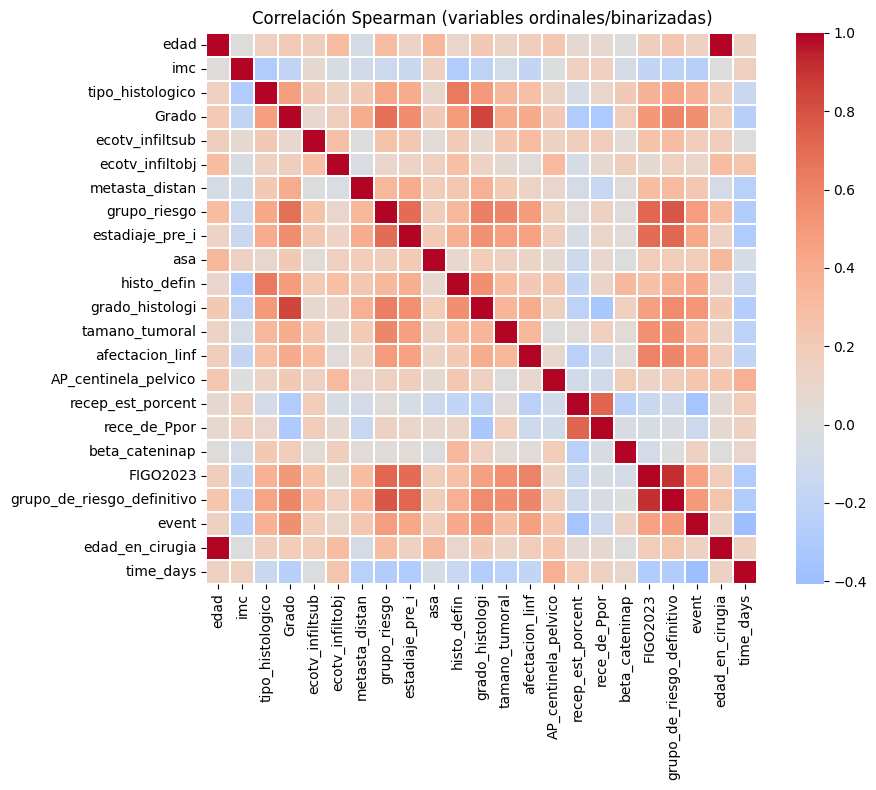

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.3
)
plt.title("Correlación Spearman (variables ordinales/binarizadas)")
plt.tight_layout()
plt.show()


In [26]:
high_corr = []

cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        rho = corr.iloc[i, j]
        if abs(rho) >= 0.75:
            high_corr.append((cols[i], cols[j], rho))

high_corr


[('edad', 'edad_en_cirugia', np.float64(0.9973127247137145)),
 ('Grado', 'grado_histologi', np.float64(0.8439411125662027)),
 ('grupo_riesgo',
  'grupo_de_riesgo_definitivo',
  np.float64(0.7813433727498099)),
 ('FIGO2023', 'grupo_de_riesgo_definitivo', np.float64(0.9141548077654353))]

In [27]:

df_pred['FIGO2023'].value_counts(dropna=False)

FIGO2023
1.0     79
4.0     15
11.0    13
NaN      9
2.0      9
7.0      4
14.0     3
9.0      3
12.0     3
13.0     3
6.0      3
10.0     2
8.0      1
Name: count, dtype: int64

In [28]:
##CAS 1: quedarnos amb grado histologic --> imputar els missing amb el valor de GRADO
df_pred["grado_final"] = df_pred["grado_histologi"]

mask = df_pred["grado_final"].isna()
df_pred.loc[mask, "grado_final"] = df_pred.loc[mask, "Grado"]

#eliminar les dues altres:
colums_drop= ['Grado', 'grado_histologi']
df_pred = df_pred.drop(columns=colums_drop)



In [29]:
#Caso 2. 
colums_drop_c2= ['grupo_riesgo', 'grupo_de_riesgo_definitivo']
df_pred = df_pred.drop(columns=colums_drop_c2)


In [30]:
csv_path_pred_1= 'Dades/var_pred_v2_postwei.csv'
df_pred.to_csv(csv_path_pred_1, index=False)

In [31]:
df_pred.columns

Index(['edad', 'imc', 'tipo_histologico', 'ecotv_infiltsub', 'ecotv_infiltobj',
       'metasta_distan', 'estadiaje_pre_i', 'asa', 'histo_defin',
       'tamano_tumoral', 'afectacion_linf', 'AP_centinela_pelvico',
       'recep_est_porcent', 'rece_de_Ppor', 'beta_cateninap', 'FIGO2023',
       'event', 'edad_en_cirugia', 'time_days', 'grado_final'],
      dtype='object')

## Clustering para identificar variables que influyen en grupo_de_riesgo_definitivo

In [32]:
# Cargar dataset con grupo_de_riesgo_definitivo
var_pred= ["edad_en_cirugia", "event", "time_days"]
df_cluster = df_pred.drop(columns=var_pred).copy()

In [33]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   edad                  147 non-null    float64
 1   imc                   145 non-null    float64
 2   tipo_histologico      147 non-null    int64  
 3   ecotv_infiltsub       146 non-null    float64
 4   ecotv_infiltobj       142 non-null    float64
 5   metasta_distan        143 non-null    float64
 6   estadiaje_pre_i       146 non-null    float64
 7   asa                   138 non-null    float64
 8   histo_defin           146 non-null    float64
 9   tamano_tumoral        129 non-null    float64
 10  afectacion_linf       140 non-null    float64
 11  AP_centinela_pelvico  128 non-null    float64
 12  recep_est_porcent     86 non-null     float64
 13  rece_de_Ppor          84 non-null     float64
 14  beta_cateninap        137 non-null    float64
 15  FIGO2023              1

In [34]:
var_drop_pre_op=['ecotv_infiltsub', 'ecotv_infiltobj']
#son preoperatories i rebundants 
var_num= ['tamano_tumoral','recep_est_porcent','rece_de_Ppor','imc']
var_catg= ['tipo_histologico', 'estadiaje_pre_i',  'asa', 'histo_defin', 'AP_centinela_pelvico','FIGO2023' ]
var_bi= ['metasta_distan', 'afectacion_linf']
var_mis_com_2=['beta_cateninap']
without_miss= ['grado_final']

In [35]:
df_cluster= df_cluster.drop(columns=var_drop_pre_op).copy()

**Catg. + Bi. Nova categoria 100**

In [36]:
# Reemplazar missing en variables categóricas con valor 100
for var in var_catg:
    if var in df_cluster.columns:
        df_cluster[var] = df_cluster[var].fillna(100)
        print(f"{var}: {df_cluster[var].isna().sum()} missings restantes")


tipo_histologico: 0 missings restantes
estadiaje_pre_i: 0 missings restantes
asa: 0 missings restantes
histo_defin: 0 missings restantes
AP_centinela_pelvico: 0 missings restantes
FIGO2023: 0 missings restantes


In [37]:
#binaries --> nova catg nº 100 
for var in var_bi:
    if var in df_cluster.columns:
        df_cluster[var] = df_cluster[var].fillna(100)
        print(f"{var}: {df_cluster[var].isna().sum()} missings restantes")

metasta_distan: 0 missings restantes
afectacion_linf: 0 missings restantes


In [38]:
#VAR ESPECIAL --> MISS = NO REALITZAR (valor 2 en metadata)
df_cluster[var_mis_com_2] = df_cluster[var_mis_com_2].fillna(2)
print(f"{var_mis_com_2}: {df_cluster[var_mis_com_2].isna().sum()} missings restantes")

['beta_cateninap']: beta_cateninap    0
dtype: int64 missings restantes


In [39]:
df_cluster

,edad,imc,tipo_histologico,metasta_distan,estadiaje_pre_i,asa,histo_defin,tamano_tumoral,afectacion_linf,AP_centinela_pelvico,recep_est_porcent,rece_de_Ppor,beta_cateninap,FIGO2023,grado_final
0,68.0,39.4,2,1.0,2.0,2.0,2.0,NaN,100.0,4.0,80.0,10.0,0.0,14.0,2.0
1,72.0,38.8,2,0.0,0.0,2.0,2.0,2.0,1.0,4.0,NaN,NaN,0.0,1.0,1.0
2,78.0,36.3,2,0.0,1.0,1.0,2.0,7.0,1.0,4.0,90.0,90.0,0.0,11.0,1.0
3,68.0,31.1,2,0.0,0.0,1.0,2.0,5.0,0.0,4.0,90.0,90.0,1.0,1.0,1.0
4,58.0,40.6,1,0.0,0.0,1.0,2.0,0.7,0.0,4.0,NaN,NaN,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,68.0,41.3,2,0.0,0.0,1.0,2.0,2.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0
143,64.0,45.7,1,100.0,0.0,2.0,1.0,3.5,0.0,100.0,NaN,NaN,2.0,100.0,1.0
144,53.0,49.0,1,0.0,0.0,1.0,1.0,3.0,100.0,0.0,NaN,NaN,1.0,100.0,1.0
145,52.0,31.1,1,100.0,0.0,1.0,1.0,NaN,100.0,100.0,NaN,0.0,0.0,100.0,1.0


**NUMERIQUES**

In [40]:
##MIRAR MISSING PREDICTORAS
missing_summary = (
    df_cluster[var_num]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame(name="pct_missing")
)

missing_summary["pct_missing"] = missing_summary["pct_missing"] * 100
missing_summary


,pct_missing
rece_de_Ppor,42.857143
recep_est_porcent,41.496599
tamano_tumoral,12.244898
imc,1.360544


In [41]:
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(strategy="median")

df_cluster[var_num] = imp_median.fit_transform(df_cluster[var_num])


In [42]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   edad                  147 non-null    float64
 1   imc                   147 non-null    float64
 2   tipo_histologico      147 non-null    int64  
 3   metasta_distan        147 non-null    float64
 4   estadiaje_pre_i       147 non-null    float64
 5   asa                   147 non-null    float64
 6   histo_defin           147 non-null    float64
 7   tamano_tumoral        147 non-null    float64
 8   afectacion_linf       147 non-null    float64
 9   AP_centinela_pelvico  147 non-null    float64
 10  recep_est_porcent     147 non-null    float64
 11  rece_de_Ppor          147 non-null    float64
 12  beta_cateninap        147 non-null    float64
 13  FIGO2023              147 non-null    float64
 14  grado_final           147 non-null    float64
dtypes: float64(14), int64(1

# Clustering JERARQUIC AMB GOWER

In [43]:
no_miss=df_cluster.copy()


In [44]:
import gower
X = no_miss.copy()

D = gower.gower_matrix(X)

In [45]:
D

array([[0.        , 0.20412153, 0.22044401, ..., 0.25150385, 0.30378693,
        0.3048218 ],
       [0.20412153, 0.        , 0.03463261, ..., 0.21162537, 0.35654467,
        0.11340444],
       [0.22044401, 0.03463261, 0.        , ..., 0.22794786, 0.3644069 ,
        0.11964699],
       ...,
       [0.25150385, 0.21162537, 0.22794786, ..., 0.        , 0.25143707,
        0.20450954],
       [0.30378693, 0.35654467, 0.3644069 , ..., 0.25143707, 0.        ,
        0.39307246],
       [0.3048218 , 0.11340444, 0.11964699, ..., 0.20450954, 0.39307246,
        0.        ]], shape=(147, 147), dtype=float32)

C:\Users\sylbo\AppData\Local\Temp\ipykernel_30404\3295152174.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method="average")


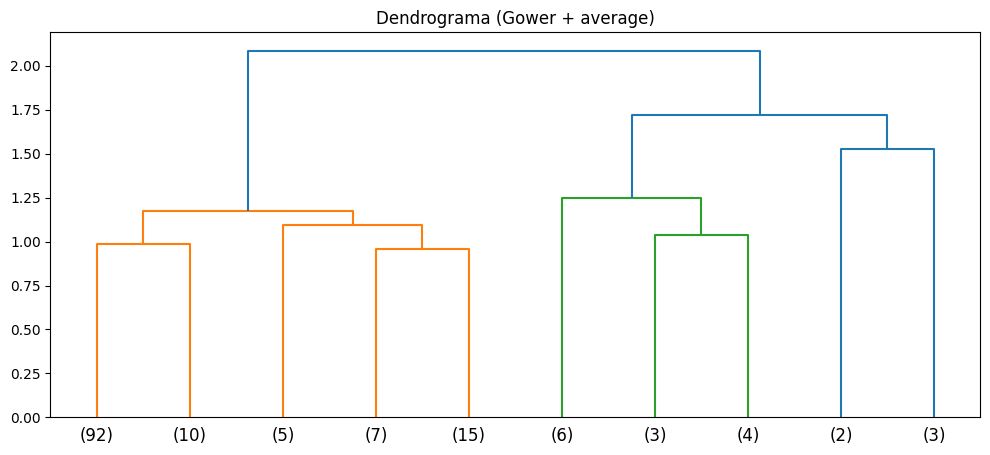

In [47]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(D, method="average")

plt.figure(figsize=(12,5))
dendrogram(Z, truncate_mode="lastp", p=10)
plt.title("Dendrograma (Gower + average)")
plt.show()


In [56]:
from scipy.cluster.hierarchy import fcluster

df_cluster["cluster_3"] = fcluster(Z, t=3, criterion="maxclust")
df_cluster["cluster_4"] = fcluster(Z, t=4, criterion="maxclust")


In [57]:
df_cluster["cluster_3"].value_counts()


cluster_3
1    129
2     13
3      5
Name: count, dtype: int64

C:\Users\sylbo\AppData\Local\Temp\ipykernel_30404\1954261482.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method="average")


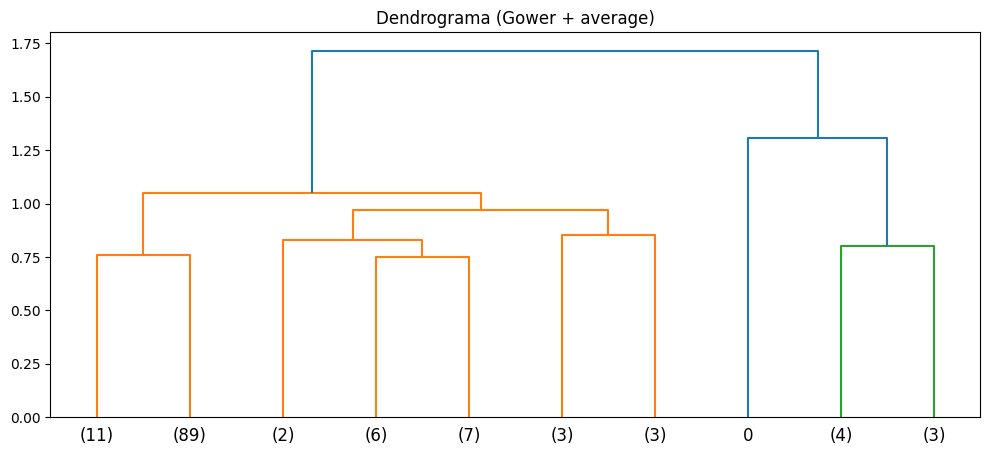

In [59]:
df_clus1= df_cluster[df_cluster["cluster_3"] == 1].copy()
D = gower.gower_matrix(df_clus1)

Z = linkage(D, method="average")

plt.figure(figsize=(12,5))
dendrogram(Z, truncate_mode="lastp", p=10)
plt.title("Dendrograma (Gower + average)")
plt.show()


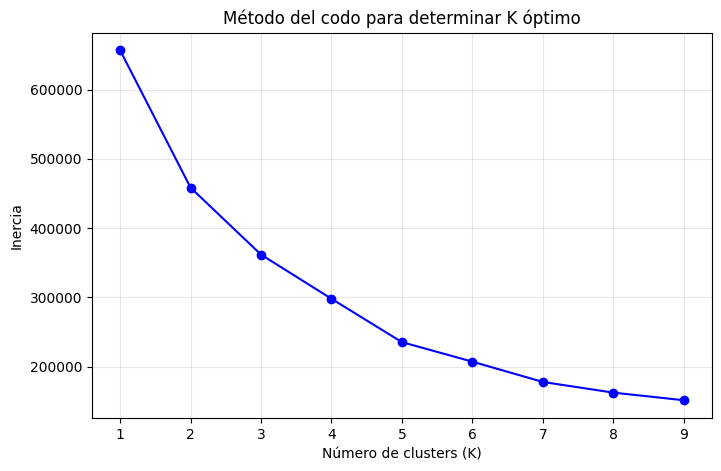

In [49]:
# Determinar número óptimo de clusters usando método del codo
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(no_miss)
    inertias.append(kmeans.inertia_)

# Visualizar método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar K óptimo')
plt.grid(True, alpha=0.3)
plt.show()

In [50]:
# Aplicar clustering con número de clusters igual a los grupos de riesgo
n_grupos_riesgo = int(y_riesgo_valid.nunique())
print(f"Número de grupos de riesgo únicos: {n_grupos_riesgo}")

kmeans = KMeans(n_clusters=n_grupos_riesgo, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

print(f"\nDistribución de clusters:")
print(pd.Series(cluster_labels).value_counts().sort_index())

NameError: name 'y_riesgo_valid' is not defined

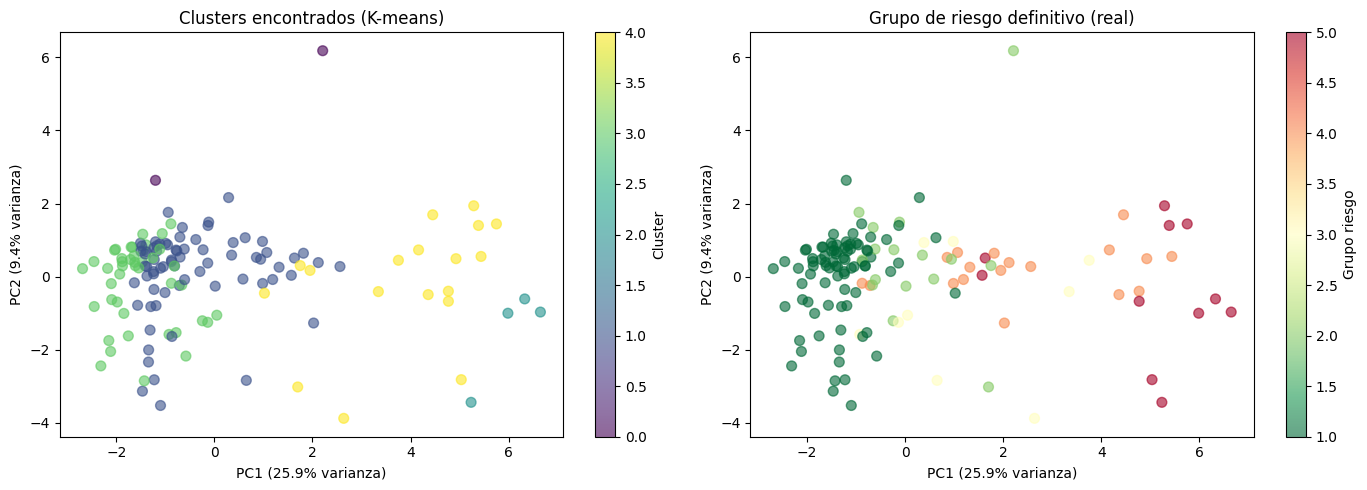


Varianza explicada por PC1 y PC2: 35.3%


In [ ]:
# Visualizar clusters en 2D usando PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Coloreado por cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
axes[0].set_title('Clusters encontrados (K-means)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Gráfico 2: Coloreado por grupo de riesgo real
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_riesgo_valid, cmap='RdYlGn_r', s=50, alpha=0.6)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
axes[1].set_title('Grupo de riesgo definitivo (real)')
plt.colorbar(scatter2, ax=axes[1], label='Grupo riesgo')

plt.tight_layout()
plt.show()

print(f"\nVarianza explicada por PC1 y PC2: {pca.explained_variance_ratio_[:2].sum():.1%}")

In [ ]:
# Comparar clusters con grupos de riesgo reales - Tabla cruzada
crosstab = pd.crosstab(
    y_riesgo_valid, 
    cluster_labels, 
    rownames=['Grupo Riesgo Real'], 
    colnames=['Cluster'],
    margins=True
)

print("Tabla cruzada: Grupo de Riesgo Real vs Clusters encontrados")
print(crosstab)

# Calcular porcentaje por fila para ver la distribución
crosstab_pct = pd.crosstab(
    y_riesgo_valid, 
    cluster_labels, 
    rownames=['Grupo Riesgo Real'], 
    colnames=['Cluster'],
    normalize='index'
) * 100

print("\n\nPorcentaje por grupo de riesgo:")
print(crosstab_pct.round(1))

Tabla cruzada: Grupo de Riesgo Real vs Clusters encontrados
Cluster            0   1  2   3   4  All
Grupo Riesgo Real                       
1.0                1  45  0  37   1   84
2.0                1  11  0   2   2   16
3.0                0   3  0   3   3    9
4.0                0  10  0   1   7   18
5.0                0   2  4   0   5   11
All                2  71  4  43  18  138


Porcentaje por grupo de riesgo:
Cluster              0     1     2     3     4
Grupo Riesgo Real                             
1.0                1.2  53.6   0.0  44.0   1.2
2.0                6.2  68.8   0.0  12.5  12.5
3.0                0.0  33.3   0.0  33.3  33.3
4.0                0.0  55.6   0.0   5.6  38.9
5.0                0.0  18.2  36.4   0.0  45.5


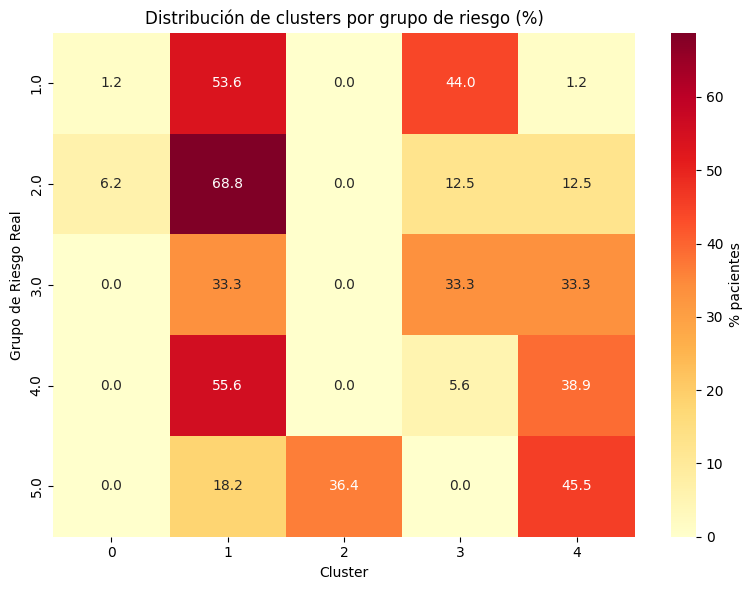

In [ ]:
# Heatmap de la tabla cruzada
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '% pacientes'})
plt.title('Distribución de clusters por grupo de riesgo (%)')
plt.ylabel('Grupo de Riesgo Real')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

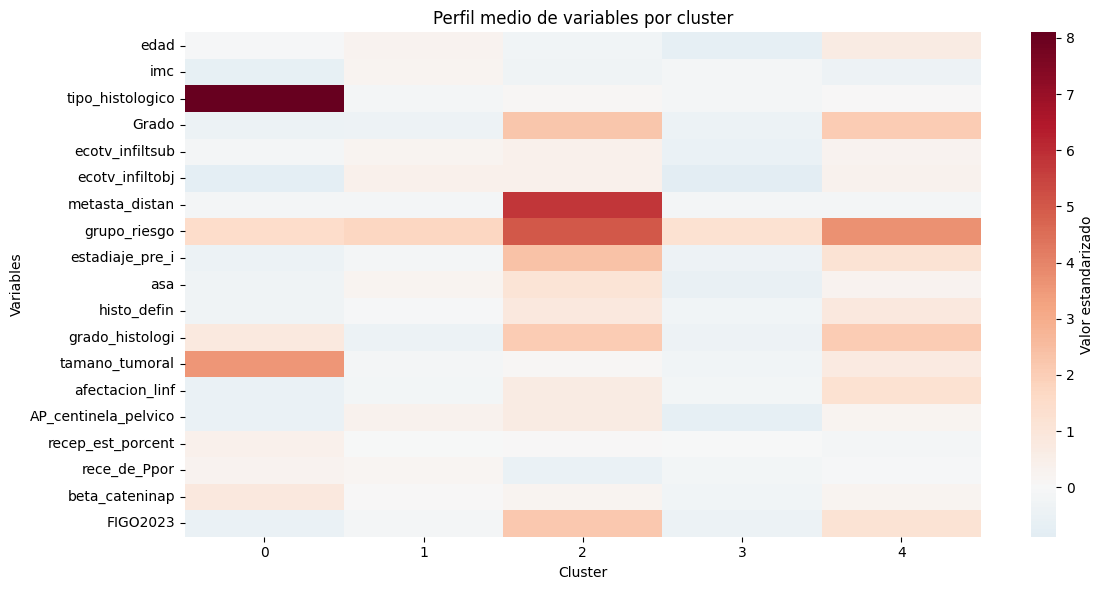

In [ ]:
# Analizar qué variables son más importantes para distinguir los clusters
# Calcular el perfil medio de cada cluster

df_analysis = pd.DataFrame(X_cluster_scaled, columns=X_cluster_valid.columns)
df_analysis['cluster'] = cluster_labels
df_analysis['grupo_riesgo'] = y_riesgo_valid.values

# Perfil medio por cluster
cluster_means = df_analysis.groupby('cluster').mean()

# Visualizar heatmap de perfiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, cmap='RdBu_r', center=0, cbar_kws={'label': 'Valor estandarizado'})
plt.title('Perfil medio de variables por cluster')
plt.xlabel('Cluster')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

Variables más discriminantes entre clusters (top 10):
            Variable     F_score       p_value
    tipo_histologico 1089.790672 1.459797e-100
               Grado  187.410729  1.261660e-53
     grado_histologi  173.542064  9.344329e-52
        grupo_riesgo   41.518061  1.499582e-22
     estadiaje_pre_i   22.973862  1.902176e-14
            FIGO2023   22.120997  5.143514e-14
     ecotv_infiltobj   19.840190  7.910091e-13
      tamano_tumoral   13.457760  3.085131e-09
                edad   12.445599  1.255458e-08
AP_centinela_pelvico   11.554660  4.415923e-08


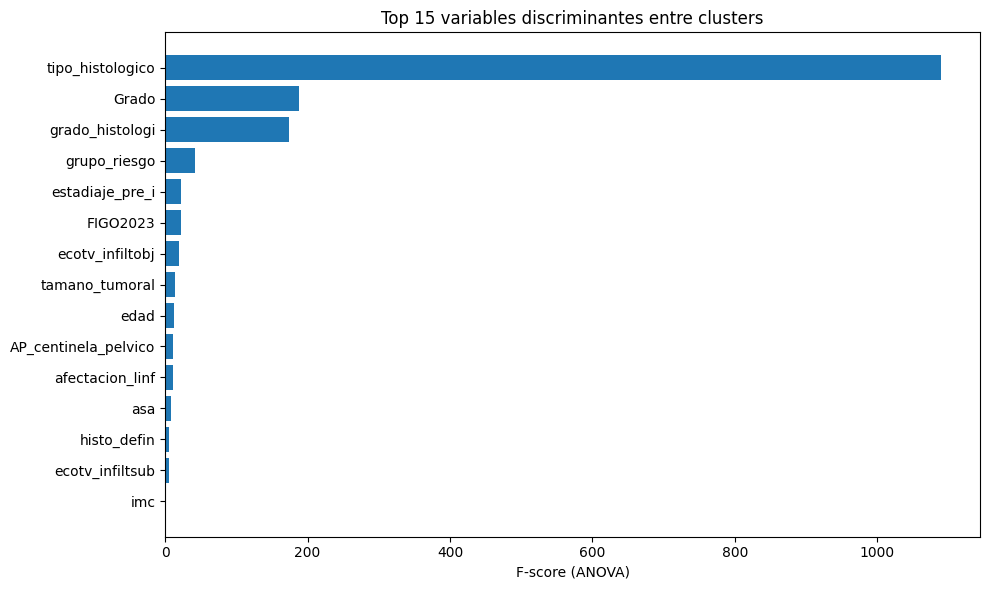

In [ ]:
# Identificar las variables más discriminantes entre clusters
# Calcular ANOVA F-score para cada variable

from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(X_cluster_scaled, cluster_labels)

# Crear DataFrame con resultados
var_importance = pd.DataFrame({
    'Variable': X_cluster_valid.columns,
    'F_score': f_scores,
    'p_value': p_values
}).sort_values('F_score', ascending=False)

print("Variables más discriminantes entre clusters (top 10):")
print(var_importance.head(10).to_string(index=False))

# Visualizar top variables
plt.figure(figsize=(10, 6))
top_n = 15
top_vars = var_importance.head(top_n)
plt.barh(range(top_n), top_vars['F_score'].values)
plt.yticks(range(top_n), top_vars['Variable'].values)
plt.xlabel('F-score (ANOVA)')
plt.title(f'Top {top_n} variables discriminantes entre clusters')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Calcular métricas de concordancia entre clusters y grupos de riesgo
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

ari = adjusted_rand_score(y_riesgo_valid, cluster_labels)
nmi = normalized_mutual_info_score(y_riesgo_valid, cluster_labels)
silhouette = silhouette_score(X_cluster_scaled, cluster_labels)

print("Métricas de evaluación del clustering:")
print(f"  - Adjusted Rand Index (ARI): {ari:.3f}")
print(f"    (1 = concordancia perfecta, 0 = aleatorio)")
print(f"  - Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"    (1 = información compartida perfecta, 0 = independientes)")
print(f"  - Silhouette Score: {silhouette:.3f}")
print(f"    (1 = clusters bien separados, -1 = mal agrupados)")

if ari > 0.3:
    print("\n✓ Los clusters se corresponden moderadamente con los grupos de riesgo")
elif ari > 0.1:
    print("\n⚠ Los clusters tienen cierta correspondencia con los grupos de riesgo")
else:
    print("\n✗ Los clusters no se corresponden bien con los grupos de riesgo")

Métricas de evaluación del clustering:
  - Adjusted Rand Index (ARI): 0.160
    (1 = concordancia perfecta, 0 = aleatorio)
  - Normalized Mutual Information (NMI): 0.233
    (1 = información compartida perfecta, 0 = independientes)
  - Silhouette Score: 0.119
    (1 = clusters bien separados, -1 = mal agrupados)

⚠ Los clusters tienen cierta correspondencia con los grupos de riesgo
